## Идея

Идея бенчмарка и реструктуризации базы данных такая:
К нам поступают запросы, их много и все они разные, нам надо оценить насколько они производительны, куда чаще всего обращаются пользователи, сюда относятся вопросы партиционрования таблиц, выделения временных таблиц и перестройка структуры базы данных.

Основная цель, быстро принимать и отдавать данные, при этом надо соблюсти минимальное представление по нагруженности линий передачи данных и сформировать быстрый и легкий иструмент.

Предлагается получать SQL запросы и оценивать их по нескольким параметрам (см. ниже), далее, так как запросы приходят у нас по времени можно рассматривать их как временной ряд (многомерный). По оси Х у вас будут временные метки, по оси Y параметры вашего запроса (их можно получить из SQL Trino, он оценивает работу SQL запроса по 150 параметрам). То есть осей Y у вас будет много.

Далее, переводим SQL запросы с временными метками и параметрами во временной ряд и строим по этом ряду граф. Затем оценивая этот граф (метрики по нему смотрит ниже) ищем "ботлнеки" и далее определяем на каком запросе что у нас тормозится и перестраиваем структуру нашей базы данных.

Ниже приведен код по получению временного ряда и построению по нему графа. Таким образом, оценивая такой граф мы в динамическом режиме видим как работает наша база данных по запросам.

При этом можно даже не собирать логи, так как все происходит в режиме реалтайма (можно также собирать для статистики). Вершины графа это SQL запросы с параметрами, ребра это связи между запросами. По SQL запросам можно восстановить структуру базы даных.

В тестовом варианте мы представили временные промежутки длинные, но их можно изменить на любые вплоть до 1 сек или 1 мкр. сек. Поддерживается самый широкий диапазон тайминга. Если два или более запроса приходят одновременно ставится метка, также можно просматривать логи от отдельного пользователя, то есть его запросы.


----------------------------

## Параметры SQL запроса (таблица №1):

- Время выполнения (Execution Time): Измеряется время, затраченное на полное выполнение запроса, включая этапы планирования, обработки и вывода результата.

- План запроса (Query Plan): Структура плана исполнения запроса помогает понять, как база данных решает выполнить запрос (использует ли индекс, какой тип соединения применяется и т.д.).

- Используемые индексы (Indexes Used): Проверка, используются ли индексы для ускорения операций чтения и фильтрации.

- Объем обработанных данных (Rows Scanned / Rows Examined): Сколько строк было фактически проверено базой данных перед выдачей результата.

- Эффективность сортировки (Sort Operations): Оценка количества операций сортировки и их влияние на общую производительность.

- Количества соединений (Joins): Анализ того, сколько таблиц участвует в соединениях и насколько эффективны используемые методы соединения.

- Загрузка ресурсов сервера (CPU, Memory Usage): Мониторинг нагрузки на процессор и память, вызванной выполнением запроса.

- Операции ввода-вывода (Disk I/O): Определение объема дисковых операций, необходимых для выполнения запроса.

- Занимаемая транзакционная нагрузка (Locks Acquired): Общее количество заблокированных объектов (таблиц, строк) и продолжительность блокировки.

- Параметр использования памяти (Memory Consumption): Объем оперативной памяти, потребляемый процессом выполнения запроса.

- Тип операции (Operation Type): Является ли запрос простым выбором данных (SELECT), изменением данных (INSERT, UPDATE, DELETE) или сложной комбинацией операций.

- Количество используемых сессий (Sessions Involved): Если запрос запускается параллельно несколькими пользователями или сеансами, можно измерить нагрузку на систему от параллельных подключений.

- Процент использования кеширования (Cache Hit Ratio): Насколько сильно используется кэшированный результат предыдущего выполнения запроса.

    - EXPLAIN PLAN (PostgreSQL, MySQL, Oracle) — даёт подробный план выполнения запроса.
    - SHOW PROFILE (MySQL) — отображает детальные профилирование запросов.
    - SET STATISTICS TIME ON (PostgreSQL) — включает вывод статистики времени выполнения.
    - DBMS_MONITOR (Oracle) — средство мониторинга работы базы данных.

- Оптимальность SQL-кода (Query Optimization): Оценка степени оптимизации запроса путем проверки наличия избыточных операций, ненужных объединений (JOIN), неоптимальных условий фильтрации (WHERE) и порядка выполнения операций.

- Отсутствие избыточных вычислений (Redundant Calculations): Определение, присутствуют ли повторяющиеся или лишние расчеты внутри запроса, которые снижают эффективность.

- Степень параллельности (Parallel Execution Degree): Некоторые СУБД поддерживают параллельное выполнение запросов. Оценка уровня параллелизма может показать возможности повышения производительности за счёт распараллеливания.

- Использование временных таблиц (Temporary Tables Usage): Использование промежуточных временных таблиц может снизить накладные расходы на последующие операции, однако оно также увеличивает потребление ресурсов.

- Нагрузка на буферный пул (Buffer Pool Load): Мониторинг размера буферного пула и частоты попадания данных в кэш. Высокая частота попаданий снижает потребность в операциях ввода-вывода.

- Регулярность выполнения (Frequency of Execution): Частое выполнение одних и тех же запросов или однотипных запросов может повлиять на общий профиль нагрузки на базу данных.

- Совместимость типов данных (Data Type Compatibility): Несоответствие типов данных между полями может привести к дополнительным преобразованиям и снижению производительности.

- Разбиение результатов (Result Partitioning): Применение механизма разбиения больших объемов данных на меньшие части (PARTITIONING) может значительно повысить производительность сложных запросов.

- Детали использования дисков (Disk Space Utilization): Размер файлов журналов и временных файлов, создаваемых запросом, может стать индикатором ресурсоемкости операции.

- Обработка транзакций (Transaction Handling): Особенности обработки транзакций (автономные, вложенные, откаты) влияют на производительность отдельных запросов и всей системы в целом.

-----------------------------

In [52]:
!pip install torch-geometric >> None
!pip install igraph >> None
!pip install optuna >> None
!pip install odfpy >> None
!pip install python-igraph >> None

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.manifold import TSNE
from scipy.spatial import Delaunay
import pandas as pd
import igraph as ig
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import optuna
import networkx as nx
import igraph as ig

import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import euclidean
import numpy as np
from math import atan2, degrees, pi
from scipy.stats import pearsonr
from scipy.spatial import ConvexHull

warnings.filterwarnings('ignore')

Каждый тикер представляет собой таблицу в базе данных, на каждую таблицу приходят запросы с параметрами. Мы оцениваем эти пареметры, например, колличество строк в запросе (можно любые другие параметры которые указаны выше в таблице №1) и ставим метку, так фомируем временной ряд где по оси X отложено значение времени, по оси Y суммарный показатель параметра.

то есть,  

-----------------------
id_запроса: 1       

Текст_запроса:
SELECT user_id, COUNT(*) AS orders_count  6
FROM orders
WHERE order_date >= '2025-01-01'
GROUP BY user_id
ORDER BY orders_count DESC;

Колличество_строк: 5

-----------------------
id_запроса: 2

Текст_запроса:
INSERT INTO products (product_name, price, category)
VALUES ('Smartphone', 699.99, 'Electronics');

Колличество_строк: 2

-----------------------
id_запроса: 3

UPDATE employees
SET salary = salary * 1.1
WHERE department = 'Sales' AND hire_date < '2020-01-01';

Колличество_строк: 3

-----------------------

            


In [54]:
# Пример: Оценка параметров графа
# Используемые индексы (Indexes Used): Проверка, используются ли индексы для ускорения операций чтения и фильтрации.

import psycopg2

def check_indexes(db_conn_params, table_name):
    conn = None
    try:
        conn = psycopg2.connect(**db_conn_params)

        with conn.cursor() as cur:
            sql_query = """
                SELECT i.relname AS index_name
                FROM pg_class t
                JOIN pg_index ix ON t.oid = ix.indrelid
                JOIN pg_class i ON i.oid = ix.indexrelid
                WHERE t.relkind = 'r' AND t.relname = %s
            """

            cur.execute(sql_query, (table_name,))
            indexes = cur.fetchall()

            if len(indexes) > 0:
                print(f"В таблице {table_name} найдены индексы:")
                for idx in indexes:
                    print(idx[0])
            else:
                print(f"В таблице {table_name} отсутствуют индексы.")

    except Exception as e:
        print("Ошибка:", str(e))
    finally:
        if conn is not None:
            conn.close()

check_indexes({'dbname': 'mydatabase', 'user': 'postgres'}, 'users')

Ошибка: connection to server on socket "/var/run/postgresql/.s.PGSQL.5432" failed: No such file or directory
	Is the server running locally and accepting connections on that socket?



## Загрузка графа

In [61]:
tickers = ["Number_of_Lines"]

Здесь мы делаем специальный алгоритм видимости графа:

Функция `visibility_graph` строит граф видимости для временного ряда. Она последовательно проверяет каждую пару точек на наличие прямой видимости друг относительно друга, используя геометрическое условие: точка считается видимой, если ни одна промежуточная точка не находится выше линии, соединяющей рассматриваемые точки. Если условие выполняется, добавляется ребро между этими вершинами графа. Таким образом, полученный граф отражает структуру временных зависимостей и взаимосвязей внутри исходного ряда данных.

Каждая точка нашего графа представляет количество строк в отдельных SQL-запросах. Алгоритм построения графа видимости позволяет выявить зависимости и связи между различными запросами по количеству возвращаемых ими строк. Например, если два запроса имеют прямую видимую связь (ребро в графе), это означает, что число строк в одном запросе непосредственно влияет на количество строк другого запроса, либо они оба зависят от общего набора условий выборки. Такой подход помогает анализировать закономерности и паттерны распределения объемов данных, выявлять аномалии или кластеры запросов с похожими характеристиками.

In [62]:
def visibility_graph(time_series):
    n = len(time_series) # колличество_вершин
    G = ig.Graph()
    G.add_vertices(n)

    time_series_np = time_series.to_numpy(dtype=np.float64)

    for i in range(n):
        for j in range(i + 1, n):
            k_values = np.arange(i + 1, j)
            visibility_condition = time_series_np[k_values] >= time_series_np[i] + (time_series_np[j] - time_series_np[i]) * (k_values - i) / (j - i)
            if not np.any(visibility_condition):
                G.add_edge(i, j)
    return G

In [63]:
graph=dict()
for name in tickers:
    data = pd.read_excel(f'/content/{name}.ods', usecols=[1], engine='odf', skipfooter=1400)
    #data=pd.read_csv(f'/content/{name}.csv', usecols=[1], skipfooter=1400)
    graph[name]=visibility_graph(data)
    print(f'Graph {name} complited!')

Graph Number_of_Lines complited!


In [64]:
graph

{'Number_of_Lines': <igraph.Graph at 0x7988910c7b50>}

# Визуализация графа

In [65]:
def plot_beautiful_visibility_graph(G, title=None):
    visual_style = {
        "vertex_color": "#FFADAD",     # Цвет вершин (мягкий розовый оттенок)
        "edge_color": "#BDE0FE",       # Цвет рёбер (голубой оттенок)
        "background_color": "#1E272E", # Фон (темно-серый оттенок)
        "vertex_size": 5,              # Размер вершин
        "edge_width": 1,               # Толщина рёбер
        "layout": G.layout_kamada_kawai(),  # Более аккуратное размещение вершин
        "bbox": (800, 800),            # Увеличенное окно для лучшей детализации
        "margin": 50                   # Поля вокруг рисунка
    }

    # Рисование графа
    fig, ax = plt.subplots(figsize=(10, 10))  # Больший размер фигуры
    ig.plot(G, target=ax, **visual_style)
    plt.title(title, color="white")          # Белый цвет заголовка для контраста
    plt.axis('off')                           # Скрываем оси координат
    plt.show()

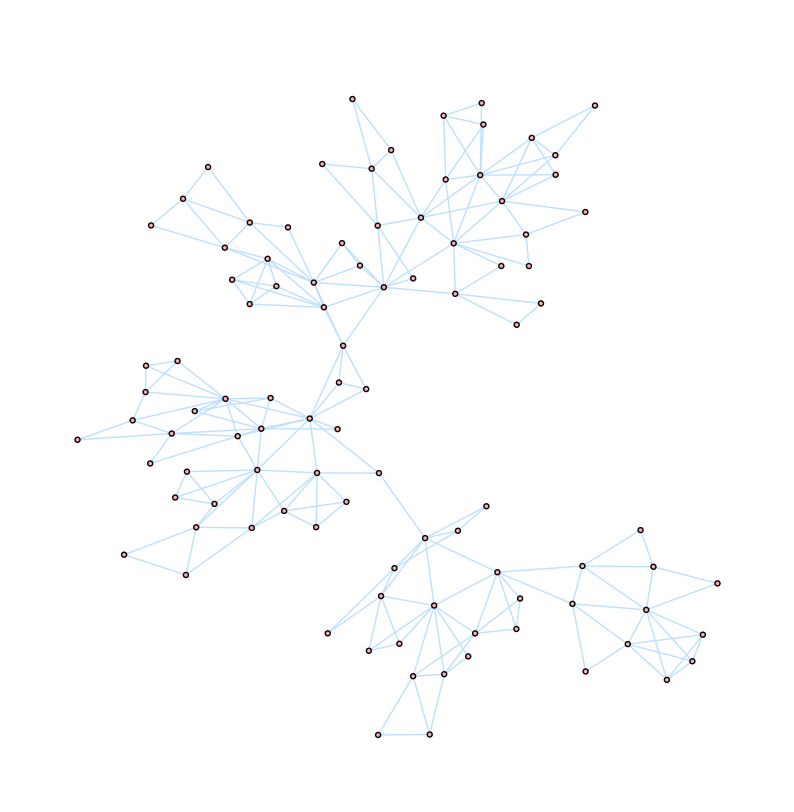

Graph Number_of_Lines completed!


In [66]:
for name in tickers:
    #data = pd.read_csv(f'/content/{name}.csv', usecols=[1],skipfooter=1400)
    data = pd.read_excel(f'/content/{name}.ods', usecols=[1], engine='odf')
    G = visibility_graph(data)
    plot_beautiful_visibility_graph(G, f'Visibility Graph for {name}')
    print(f'Graph {name} completed!')

Судя по этому графу у нас есть три явные кластера запросов, оценивая параметры этого графа можно сказать, надо пересобирать базу или нет. Ниже эти параметры мы привели.

In [67]:
# Конвертация_графа_в_другой_формат
igraph_G = G
nx_G = nx.Graph()
for edge in igraph_G.es:
    source_vertex_id = edge.source
    target_vertex_id = edge.target
    nx_G.add_edge(source_vertex_id, target_vertex_id)

In [68]:
# Получаем_координаты_вершин

positions = nx.spring_layout(nx_G)
for vertex, coord in positions.items():
    print(f"Вершина {vertex}: Координаты ({coord[0]}, {coord[1]})")

Вершина 0: Координаты (-0.23850629819683716, -0.19356881538914583)
Вершина 1: Координаты (-0.2535625732973844, -0.2439204476051057)
Вершина 2: Координаты (-0.07729796108011713, -0.1887983593753625)
Вершина 3: Координаты (0.04553489281205517, -0.2103892961143188)
Вершина 4: Координаты (0.13267759461255552, -0.2708428739628017)
Вершина 25: Координаты (-0.044937972711442016, -0.02465510629170293)
Вершина 5: Координаты (0.26102385382491283, -0.2577827484426534)
Вершина 6: Координаты (0.2904244059730313, -0.3151020005989763)
Вершина 8: Координаты (0.28385479255201784, -0.39398229025712767)
Вершина 13: Координаты (0.2604294932430459, -0.4530036115495568)
Вершина 17: Координаты (0.18895378782547304, -0.43640947954043746)
Вершина 18: Координаты (0.08533166709921332, -0.3078484695142401)
Вершина 7: Координаты (0.3933558079305078, -0.3562128486412234)
Вершина 9: Координаты (0.3496780866018565, -0.5009442296774739)
Вершина 10: Координаты (0.3966084999266438, -0.506935985441353)
Вершина 12: Коорди

In [69]:
positions[43]

array([0.3530414, 0.3396415])

In [70]:
nx_G

## Параметры графа

In [71]:
# 1. Минимальное расстояние между вершинами (Minimum distance between vertices, MDBV)
'''
Минимальное евклидово расстояние между двумя любыми вершинами. Чем больше этот
показатель, тем меньше вероятность наложения вершин.

Алгоритм:
- Использовать Spring Layout для определения позиций вершин (или загрузить ранее рассчитанные координаты).
- Вычислить Евклидовы расстояния между всеми парами вершин.
- Найти минимальное среди полученных расстояний.
'''

def calculate_minimum_distance_between_vertices(graph):
    positions = nx.spring_layout(graph, seed=42)

    min_dist = float('inf')  # Начальное минимальное расстояние бесконечно большое

    # Перебираем все пары вершин и считаем расстояние между ними
    for u in graph.nodes():
        x_u, y_u = positions[u]

        for v in graph.nodes():
            if u != v:  # Вершины не сравниваются сами с собой
                x_v, y_v = positions[v]

                dist = euclidean((x_u, y_u), (x_v, y_v))
                if dist < min_dist:
                    min_dist = dist

    return min_dist

calculate_minimum_distance_between_vertices(nx_G)

0.01801356680884983

In [72]:
# 2. Дисперсия длин рёбер (Dispersion of edge lengths, DEL)
'''
Степень разброса длин рёбер вокруг среднего значения. Маленькая дисперсия предпочтительна,
поскольку длинные и короткие рёбра ухудшают читаемость графа.

Алгоритм:
- Получаем позиции вершин (координаты);
- Рассчитываем длину каждого ребра, используя Евклидово расстояние;
- Вычисляем дисперсию длин рёбер относительно их среднего значения.
'''
def dispersion_of_edge_lengths(graph, pos):
    edge_lengths = []

    for u, v in graph.edges():
        coord_u = pos[u]
        coord_v = pos[v]
        length = euclidean(coord_u, coord_v)
        edge_lengths.append(length)

    variance = np.var(edge_lengths)
    return variance

dispersion_of_edge_lengths(nx_G, positions)

np.float64(0.0050914621491376195)

In [73]:
# 3. Максимальное отклонение углов (Maximum angle deviation, MAD)
'''
Максимальное отклонение углов (Maximum angle deviation, MAD): максимальное отклонение угла,
образованного парой смежных рёбер одной вершины, от идеала ($120^\circ$ или другого
оптимального угла). Идеальные углы способствуют лучшему восприятию локальной структуры графа.

Алгоритм:
- Определяем направления рёбер, исходящих из каждой вершины;
- Рассчитываем углы между этими направлениями;
- Оцениваем максимальное отклонение этих углов от идеального угла​.
'''
def maximum_angle_deviation(graph, pos=positions, ideal_angle=120):
    max_deviation = 0

    def vector(u, v):
        """Возвращает вектор от вершины u к вершине v."""
        return np.array(pos[v]) - np.array(pos[u])

    def angle_between_vectors(v1, v2):
        """Рассчитывает угол между векторами в градусах."""
        dx1, dy1 = v1
        dx2, dy2 = v2
        a1 = atan2(dy1, dx1)
        a2 = atan2(dy2, dx2)
        delta = abs(degrees(a1 - a2))
        if delta > 180:
            delta = 360 - delta
        return delta

    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        n_neighbors = len(neighbors)
        if n_neighbors >= 2:
            angles = []
            for i in range(n_neighbors):
                vec1 = vector(node, neighbors[i])
                for j in range(i + 1, n_neighbors):
                    vec2 = vector(node, neighbors[j])
                    angle = angle_between_vectors(vec1, vec2)
                    angles.append(angle)
            deviations = [abs(angle - ideal_angle) for angle in angles]
            local_max_deviation = max(deviations)
            max_deviation = max(max_deviation, local_max_deviation)

    return max_deviation

maximum_angle_deviation(nx_G, pos=positions, ideal_angle=120)

119.99722606830954

In [74]:
# 4. Площадь покрытия (Coverage area, CA)
'''
Площадь минимальной ограничивающей фигуры (прямоугольника или эллипса), охватывающей весь
граф. Меньшая площадь означает более компактное представление графа.

Алгоритм:
- Собрираем координаты всех вершин графа;
- Находим минимальные и максимальные координаты по осям X и Y;
- Площадь прямоугольника вычисляется как произведение разницы по оси X на разницу по оси Y.
'''
def coverage_area(graph, pos=positions):
    coords_x = [pos[node][0] for node in graph.nodes()]
    coords_y = [pos[node][1] for node in graph.nodes()]

    min_x, max_x = min(coords_x), max(coords_x)
    min_y, max_y = min(coords_y), max(coords_y)

    area = (max_x - min_x) * (max_y - min_y)
    return area

coverage_area(nx_G, positions)

np.float64(2.864354971871922)

In [75]:
# 5. Расстояние центров масс компонентов (Distance of centers of mass of components, DCMC)
'''
Среднее расстояние между центрами масс компонент связности графа. Компактная группа
компонент облегчает понимание взаимосвязей между частями графа.

Алгоритм:
- Каждую компоненту связности рассматриваем как отдельную группу вершин;
- Центр массы компонента — это среднее арифметическое координат всех вершин компоненты;
- Расстояние между центроидами компонентов рассчитывается как среднее расстояние между этими центроидами.
'''
def distance_of_centers_of_mass_components(graph,  pos=positions):
    connected_components = list(nx.connected_components(graph.to_undirected()))
    centroids = []  # Центры масс каждой компоненты

    for component in connected_components:
        comp_coords = np.array([pos[node] for node in component])
        centroid = np.mean(comp_coords, axis=0)
        centroids.append(centroid)

    distances = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            dist = np.linalg.norm(np.array(centroids[i]) - np.array(centroids[j]))
            distances.append(dist)
    dcmc = np.mean(distances)
    return dcmc

distance_of_centers_of_mass_components(nx_G, positions)

np.float64(nan)

In [76]:
# 6. Симметрия (Symmetry, Sym)
'''
Симметрия (Symmetry, Sym): насколько точно график отражает наличие
симметрий в исходной структуре графа. Симметричность важна для
естественного восприятия и лучшего запоминания графа.

Алгоритм:
- Определяем ось симметрии (вертикально проходящую линию);
- Сопоставляем вершины слева и справа от оси;
- Подсчитаем сумму квадратичных отклонений в координатах между соответствующими вершинами;
- Используем нормировку, чтобы получить коэффициент симметрии от 0 до 1.
'''
def symmetry_metric(graph,  pos=positions):
    all_x = [coord[0] for coord in pos.values()]
    center_x = np.median(all_x)

    left_nodes = {}
    right_nodes = {}

    for node, xy in pos.items():
        if xy[0] < center_x:
            left_nodes[node] = xy
        elif xy[0] > center_x:
            right_nodes[node] = xy
    closest_pairs = []
    used_right = set()

    for l_node, l_coord in left_nodes.items():
        best_match = None
        min_dist = float('inf')
        for r_node, r_coord in right_nodes.items():
            if r_node not in used_right:
                dist = np.linalg.norm(np.array(l_coord) - np.array(r_coord))
                if dist < min_dist:
                    min_dist = dist
                    best_match = r_node
        if best_match:
            closest_pairs.append((l_node, best_match))
            used_right.add(best_match)

    asymmetry = 0
    for pair in closest_pairs:
        l_node, r_node = pair
        l_coord = pos[l_node]
        r_coord = pos[r_node]
        asymmetry += np.abs(center_x - (l_coord[0] + r_coord[0])/2)**2

    sym = 1 - (asymmetry / len(closest_pairs))
    return sym

symmetry_metric(nx_G, positions)

np.float64(0.9853804294029385)

In [77]:
# 7. Регулярность формы (Regularity of form, RF)
'''
Равномерность размеров и форм областей около каждой вершины. Равномерные области делают
граф более привлекательным и удобным для чтения.

Алгоритм:
- Рассмотрим радиус окрестности каждой вершины;
- Возьмем среднее расстояние до ближайших соседей и сравним его с аналогичными показателями для других вершин;
- Таким образом, равномерность формы оценивается по сходству этих показателей между разными вершинами.
'''
def regularity_of_form(graph,  pos=positions):
    densities = []

    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        neighbor_coords = [pos[nbr] for nbr in neighbors]
        current_node_position = pos[node]
        distances = [np.linalg.norm(current_node_position - np.array(nc)) for nc in neighbor_coords]
        mean_distance = np.mean(distances) if distances else 0
        densities.append(mean_distance)
    std_density = np.std(densities)
    rf = 1 - (std_density / np.max(densities))
    return rf

regularity_of_form(nx_G, positions)

np.float64(0.8849221892046869)

In [78]:
# 8. Соотношение сторон окна (Window aspect ratio, WR)
'''
Отношение ширины к высоте прямоугольника, содержащего всю картину. Соблюдение стандартных
соотношений сторон улучшает комфорт просмотра и печати графики.

Алгоритм:
- Необходимо определить крайние координаты (минимумы и максимумы) всех вершин.
- Исходя из них, вычисляем ширину и высоту видимой области.
- Наконец, вычисляем соотношение сторон.
'''
def window_aspect_ratio(graph,  pos=positions):
    xs = [pos[node][0] for node in graph.nodes()]
    ys = [pos[node][1] for node in graph.nodes()]

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    width = max_x - min_x
    height = max_y - min_y

    wr = width / height
    return wr

window_aspect_ratio(nx_G, positions)

np.float64(1.218579742421528)

In [79]:
# 9. Среднее абсолютное отклонение длины рёбер (Mean Absolute Edge Length Deviation, MAELD)
'''
Среднее абсолютное отклонение длины рёбер (Mean Absolute Edge Length Deviation, MAELD):
Среднее арифметическое значений модуля разницы между длиной каждого ребра и средней
длиной всех рёбер. Применяется для измерения однородности длин рёбер, помогает выявить
неравномерности и чрезмерные искажения.

Алгоритм:
- Рассчитайте длину каждого ребра;
- Найдите среднюю длину рёбер;
- Вычислите модуль отклонения каждой длины ребра от средней;
- Усредните полученные модули отклонений;
'''
def mean_absolute_edge_length_deviation(graph,  pos=positions):
    edge_lengths = []
    for u, v in graph.edges():
        edge_lengths.append(euclidean(pos[u], pos[v]))
    mean_length = np.mean(edge_lengths)
    absolute_deviations = [abs(el - mean_length) for el in edge_lengths]
    maeld = np.mean(absolute_deviations)
    return maeld

mean_absolute_edge_length_deviation(nx_G, positions)

np.float64(0.05394713455323262)

In [80]:
# 10. Огибающая линия контура графа (Graph Contour Envelope, GCE)
'''
Расстояние от внешних границ сетки до ближайшей вершины графа. Используется для оценки
компактности графического представления и определения размера необходимого холста.

Алгоритм
- Нам нужны координаты всех вершин графа;
- Вычисляем минимальную дистанцию от внешней рамки окна (обычно прямоугольника) до ближайшей вершины;
- Чем меньше GCE, тем компактнее и эффективнее визуализация.
'''

def graph_contour_envelope(graph,  pos=positions):
    xs = [pos[node][0] for node in graph.nodes()]
    ys = [pos[node][1] for node in graph.nodes()]

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    width = max_x - min_x
    height = max_y - min_y

    gce_left = min_x
    gce_right = width - max_x

    gce_top = min_y
    gce_bottom = height - max_y

    gce = min(gce_left, gce_right, gce_top, gce_bottom)
    return gce

graph_contour_envelope(nx_G, positions)

np.float64(-1.0)

In [81]:
# 11. Угол поворота (Angle Preservation Metric, APM)
'''
Измеряет отклонение реальных углов от теоретически ожидаемых величин.
Важна для сохранения геометрических особенностей графа,
например, ортогонального или почти-ортогонального размещения рёбер.

Алгоритм:
- Рассчитываются углы между всеми рёбрами.
- Для каждого ребра вычисляется разница между фактическим углом и идеальным углом.
- Усредняется сумма отклонений для всей сети.
'''
def angle_preservation_metric(graph,  pos=positions):
    def get_angle(x1, y1, x2, y2):
        return atan2(y2-y1, x2-x1)

    angles = []

    for u, v in graph.edges():
        ux, uy = pos[u]
        vx, vy = pos[v]
        angle_uv = get_angle(ux, uy, vx, vy)
        angles.append(angle_uv)

    normalized_angles = [(a + pi) % (2*pi) - pi for a in angles]
    mean_angle = np.mean(normalized_angles)
    angular_deviations = [abs(a - mean_angle) for a in normalized_angles]

    apm = np.mean(angular_deviations)
    return apm

angle_preservation_metric(nx_G,  pos=positions)

np.float64(1.4407980046822344)

In [82]:
# 12. Критерий корреляции взаиморасположения (Proximity Correlation Criterion, PCC)
'''
Статистическая оценка зависимости между расстояниями вершин в графе и
соответствующими путями. Позволяет измерять, насколько близкое положение
вершин соответствует близости в графовом смысле.

Алгоритм:
- Рассчитывать кратчайшие пути между всеми парами вершин;
- Находить соответствующие расстояния между вершинами в визуализации;
- Использовать коэффициент корреляции Пирсона для оценки соответствия между этими наборами данных.
'''

def proximity_correlation_criterion(graph,  pos=positions):
    path_matrix = dict(nx.all_pairs_shortest_path_length(graph))

    graph_distances = []
    visual_distances = []

    for u in graph.nodes():
        for v in graph.nodes():
            if u != v:
                graph_dist = path_matrix[u].get(v, float('inf'))
                graph_distances.append(graph_dist)

                vis_dist = np.linalg.norm(np.array(pos[u]) - np.array(pos[v]))
                visual_distances.append(vis_dist)

    corr_coef, _ = pearsonr(graph_distances, visual_distances)
    return corr_coef

proximity_correlation_criterion(nx_G,  pos=positions)

np.float64(0.5167019596949234)

In [83]:
# 13. Показатель осевого выравнивания (Axis Alignment Index, AAI)
'''
Показатель осевого выравнивания (Axis Alignment Index, AAI): Определяет долю рёбер,
ориентированных вдоль основных координатных осей. Полезен для построения удобочитаемых
представлений плоских графов, особенно в инженерии и дизайне.

Алгоритм:
- Рассчитайте направление каждого ребра;
- Проверьте, направлено ли ребро строго вертикально или горизонтально;
- Подсчитайте долю таких рёбер от общего числа рёбер.
'''

def axis_alignment_index(graph, pos=positions):
    aligned_edges = 0
    total_edges = len(graph.edges())

    for u, v in graph.edges():
        ux, uy = pos[u]
        vx, vy = pos[v]

        if np.isclose(uy, vy) or np.isclose(ux, vx):
            aligned_edges += 1

    aai = aligned_edges / total_edges
    return aai

axis_alignment_index(nx_G, pos=positions)

0.0

In [84]:
# 14. Относительная разница между максимальным и средним расстоянием (Relative Distance Difference Ratio, RDDR)
'''
Относительная разница между максимальным и средним расстоянием (Relative Distance Difference Ratio, RDDR):
Соотношение максимального и среднего расстояния между парами вершин. Используется для проверки
пропорциональности масштаба, предотвращения появления больших пустых зон или чрезмерной концентрации вершин.

Алгоритм:
- Рассчитываем расстояния между всеми парами вершин;
- Находим максимальное и среднее расстояния;
- РДДР вычисляется как отношение максимальной дистанции к среднему расстоянию.
'''

def relative_distance_difference_ratio(graph, pos=positions):
    if pos is None:
        pos = nx.spring_layout(graph, seed=42)

    distances = []
    for u in graph.nodes():
        for v in graph.nodes():
            if u != v:
                dist = np.linalg.norm(np.array(pos[u]) - np.array(pos[v]))
                distances.append(dist)

    max_dist = np.max(distances)
    mean_dist = np.mean(distances)

    rddr = max_dist / mean_dist
    return rddr

relative_distance_difference_ratio(nx_G, positions)

np.float64(2.4052547313008397)

In [85]:
# 15. Размер краевых выпуклых оболочек (Convex Hull Size of Edges, CHSE):
'''
Размер краевых выпуклых оболочек (Convex Hull Size of Edges, CHSE):
Площадь наименьшей выпуклой оболочки, покрывающей набор концов рёбер.
Демонстрирует эффективность упаковки графического изображения и уровень
избыточности.
'''
def convex_hull_size_of_edges(graph, pos=positions):
    points = []

    for u, v in graph.edges():
        points.append(pos[u])
        points.append(pos[v])

    hull = ConvexHull(points)

    chse = hull.volume
    return chse

convex_hull_size_of_edges(nx_G, positions)

1.692265035067961

#  Модель графа и реструктуризация базы данных

Здесь мы пытаемся сделать переупаковку нашего графа и понять как его лучше разместить то есть уложить чтобы пересобрать базу данных, то есть мы пошли от метода восстановления запросов по пути к восстановлению структуры базы по ним.

Для поиска (bottlenecks) в нашем графе можно использовать анализ центральности вершин (degree centrality, betweenness centrality, closeness centrality и прочие параметры), выявление плотных подграфов и распределённых путей. Особое внимание уделяем параметрам минимального расстояния между вершинами (MDBV), средней длине рёбер (MAELD) и относительной разницы расстояний (RDDR), так как они помогают выявить участки с максимальной нагрузкой и длительными путями прохождения запросов, определяющими узкие места сети.

In [86]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Training on GPU.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Training on CPU.')

CUDA is not available. Training on CPU.


In [87]:
torch.autograd.set_detect_anomaly(True)
class GraphLayoutEvaluator(nn.Module):
    def __init__(self, num_node_features, num_layers=2, hidden_dim=64, num_heads=8):
        super(GraphLayoutEvaluator, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        self.convs = nn.ModuleList()
        self.convs.append(GATConv(num_node_features, hidden_dim, heads=num_heads))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads))

        self.fc = nn.Linear(hidden_dim * num_heads, 1)

    def forward(self, data):
            x, edge_index = data.x, data.edge_index

            for i in range(self.num_layers):
                x = self.convs[i](x, edge_index)
                x = F.relu(x)

            x = torch.mean(x, dim=0)

            quality_score = torch.sigmoid(self.fc(x))
            return quality_score

    def calculate_edge_length_loss(self,data):
        """Calculates the total edge length loss (PyTorch compatible)."""
        x, edge_index = data.x, data.edge_index

        start_pos = x[edge_index[0], :2]
        end_pos = x[edge_index[1], :2]

        edge_lengths = torch.norm(start_pos - end_pos, dim=1)
        total_length = torch.sum(edge_lengths)

        return total_length

    def calculate_crossing_number(self, data, initial_temperature=1.0):
        """Calculates the number of edge crossings using Gumbel-Softmax with log_softmax."""
        x, edge_index = data.x, data.edge_index
        num_edges = edge_index.shape[1]

        edges_start = x[edge_index[0], :2]
        edges_end = x[edge_index[1], :2]

        def orientation(p, q, r):
            return (q[:, 1] - p[:, 1]) * (r[:, 0] - q[:, 0]) - (q[:, 0] - p[:, 0]) * (r[:, 1] - q[:, 1])

        def do_intersect(p1, q1, p2, q2):
            o1 = orientation(p1, q1, p2)
            o2 = orientation(p1, q1, q2)
            o3 = orientation(p2, q2, p1)
            o4 = orientation(p2, q2, q1)

            probabilities = torch.sigmoid(-(o1 * o2)) * torch.sigmoid(-(o3 * o4))
            return probabilities

        edge_indices = torch.arange(num_edges)
        edge_pairs = torch.combinations(edge_indices, r=2)

        p1 = edges_start[edge_pairs[:, 0]]
        q1 = edges_end[edge_pairs[:, 0]]
        p2 = edges_start[edge_pairs[:, 1]]
        q2 = edges_end[edge_pairs[:, 1]]

        intersection_probs = do_intersect(p1, q1, p2, q2)

        temperature = torch.nn.Parameter(torch.tensor(initial_temperature, requires_grad=True))
        temperature = torch.clamp(temperature, min=0.1, max=10.0)

        epsilon = 1e-8
        intersection_probs = torch.clamp(intersection_probs, min=epsilon, max=1.0)
        log_probs = torch.log(intersection_probs)
        log_probs = torch.clamp(log_probs, min=-100, max=100)

        gumbel_noise = -torch.log(-torch.log(torch.rand_like(log_probs)))
        gumbel_noise = torch.clamp(gumbel_noise, min=-100, max=100)

        before_log_softmax = (log_probs + gumbel_noise) / temperature
        before_log_softmax = torch.clamp(before_log_softmax, min=-100, max=100)

        soft_intersections_log = F.log_softmax(before_log_softmax, dim=0)
        soft_intersections = torch.exp(soft_intersections_log)
        soft_intersections = torch.clamp(soft_intersections, min=0, max=1)
        expected_crossings = torch.sum(soft_intersections)
        return expected_crossings

    def calculate_density_variation_loss(self,data, grid_size=5):
        """Calculates the density variation loss using torch.scatter_add."""
        x = data.x[:, :2]

        min_x = torch.min(x[:, 0])
        min_y = torch.min(x[:, 1])
        max_x = torch.max(x[:, 0])
        max_y = torch.max(x[:, 1])

        grid_rows = ((x[:, 1] - min_y) / (max_y - min_y) * grid_size).long()
        grid_cols = ((x[:, 0] - min_x) / (max_x - min_x) * grid_size).long()

        grid_rows = torch.clamp(grid_rows, 0, grid_size - 1)
        grid_cols = torch.clamp(grid_cols, 0, grid_size - 1)

        linear_index = grid_rows * grid_size + grid_cols
        grid = torch.zeros(grid_size * grid_size, device=x.device, requires_grad=True)
        ones = torch.ones(x.shape[0], dtype=torch.float, device=x.device)
        grid = torch.scatter_add(grid, 0, linear_index, ones)
        grid = grid.reshape((grid_size, grid_size))

        mean_density = torch.mean(grid)
        loss = torch.sum((grid - mean_density) ** 2)

        return loss

    def calculate_angle_loss(self,data):
        """Calculates the angle loss to maximize angles between edges."""
        x, edge_index = data.x, data.edge_index
        total_loss = 0.0
        for node_index in range(x.shape[0]):
            neighbor_indices = []
            for i in range(edge_index.shape[1]):
                if edge_index[0, i] == node_index:
                    neighbor_indices.append(edge_index[1, i])
                elif edge_index[1, i] == node_index:
                    neighbor_indices.append(edge_index[0, i])

            if len(neighbor_indices) >= 2:
                angles = []
                for i in range(len(neighbor_indices)):
                    for j in range(i + 1, len(neighbor_indices)):
                        neighbor1 = neighbor_indices[i]
                        neighbor2 = neighbor_indices[j]

                        vec1 = x[neighbor1, :2] - x[node_index, :2]
                        vec2 = x[neighbor2, :2] - x[node_index, :2]

                        dot_product = torch.dot(vec1, vec2)
                        magnitudes = torch.norm(vec1) * torch.norm(vec2)
                        if magnitudes > 0:
                            angle = torch.acos(dot_product / magnitudes)
                            angles.append(angle)

                if angles:
                    min_angle = min(angles)
                    total_loss += torch.relu(torch.tensor(0.785) - min_angle)

        return total_loss

    def total_loss(self,data, w_crossing=1.0, w_length=1.0, w_density=1.0, w_angle = 1.0):
        """Calculates the total loss."""
        crossing_loss = self.calculate_crossing_number(data)
        length_loss = self.calculate_edge_length_loss(data)

        density_loss = self.calculate_density_variation_loss(data)
        angle_loss = self.calculate_angle_loss(data)
        total =  w_crossing * crossing_loss + w_length * length_loss + w_density * density_loss + w_angle * angle_loss
        return total

In [88]:
def create_graph_data(graph, layout_algorithm):
    """Creates a torch_geometric.data.Data object from an igraph.Graph and a layout algorithm."""
    if layout_algorithm == "random":
        layout = graph.layout_random()
    else:
        layout = graph.layout(layout_algorithm)

    node_positions_initial = torch.tensor(layout.coords, dtype=torch.float)

    if torch.isnan(node_positions_initial).any():
        print("Предупреждение: node_positions_initial содержит NaN!")
        node_positions_initial = torch.nan_to_num(node_positions_initial, nan=0.0)
    if torch.isinf(node_positions_initial).any():
        print("Предупреждение: node_positions_initial содержит inf!")
        node_positions_initial = torch.clamp(node_positions_initial, min=-1e8, max=1e8)

    min_coords = node_positions_initial.min(dim=0, keepdim=True).values.detach()
    max_coords = node_positions_initial.max(dim=0, keepdim=True).values.detach()

    if torch.any(max_coords == min_coords):
        print("Warning: max_coords == min_coords.  Setting node_positions to zero.")
        node_positions = torch.zeros_like(node_positions_initial)
    else:
        min_coords = torch.clamp(min_coords, min=-1e8, max=1e8)
        max_coords = torch.clamp(max_coords, min=-1e8, max=1e8)
        node_positions = (node_positions_initial - min_coords) / (max_coords - min_coords)
    node_positions.requires_grad_(True)

    edge_index = torch.tensor(list(graph.get_edgelist()), dtype=torch.long).t().contiguous()
    node_degrees = torch.tensor(graph.degree(), dtype=torch.float).unsqueeze(1)
    x = torch.cat([node_positions, node_degrees], dim=1)

    data = Data(x=x, edge_index=edge_index)

    return data

In [89]:
if __name__ == '__main__':
    num_graphs = 14

    data_list = []
    layout_algorithms = ["kamada_kawai"]
    for g in graph.values():
        for layout_algorithm in layout_algorithms:
            data = create_graph_data(g,layout_algorithm)
            data_list.append(data)

    batch_size = 16
    learning_rate = 0.0000001
    num_epochs = 15
    num_node_features = data_list[0].x.shape[1]

    def objective(trial):
        num_layers = trial.suggest_int('num_layers', 2, 4, 8)
        hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256])
        num_heads = trial.suggest_categorical('num_heads', [4, 8, 16, 32])

        model = GraphLayoutEvaluator(num_node_features=num_node_features,
                                     num_layers=num_layers,
                                     hidden_dim=hidden_dim,
                                     num_heads=num_heads)
        optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate,
                                      #betas=(beta1, beta2),
                                      #eps=epsilon,
                                      #weight_decay=l2_penalty,
                                      amsgrad=False)
        model.train()
        loss_history = {'general':[],'crossing_loss':[],'length_loss':[],'density_loss':[],'angle_loss':[]}
        for epoch in range(num_epochs):
            random.shuffle(data_list)
            epoch_loss=0
            for i in range(0, len(data_list), batch_size):
                batch = data_list[i:i + batch_size]
                optimizer.zero_grad()

                loss = 0.0
                crossing_loss, length_loss, density_loss, angle_loss = 0,0,0,0
                for data in batch:
                    quality_score = model(data)
                    loss += model.total_loss(data)
                    break
                loss /= len(batch)
                epoch_loss+=loss

                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

            # Print progress
            print(f"Epoch {epoch+1}, Loss: {epoch_loss.item()}")
            loss_history['general'].append(epoch_loss.item())

        print("Training finished.")
        return loss_history['general'][-1]


    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=32)

    best_params = study.best_params
    best_loss = study.best_value

    print(f"Best parameters: {best_params}, Best loss: {best_loss}")

ValueError: number of iterations must be positive